<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

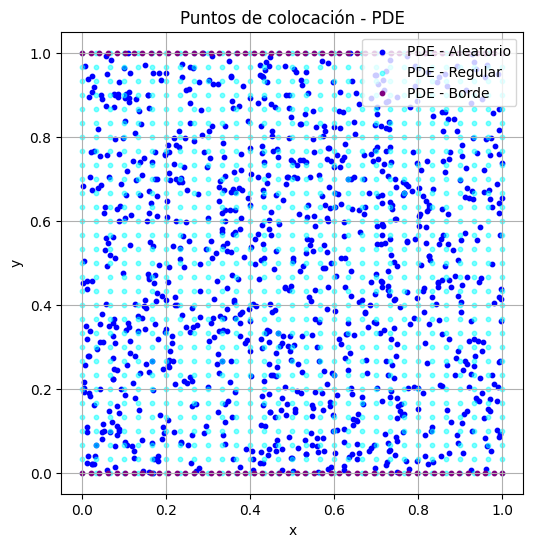

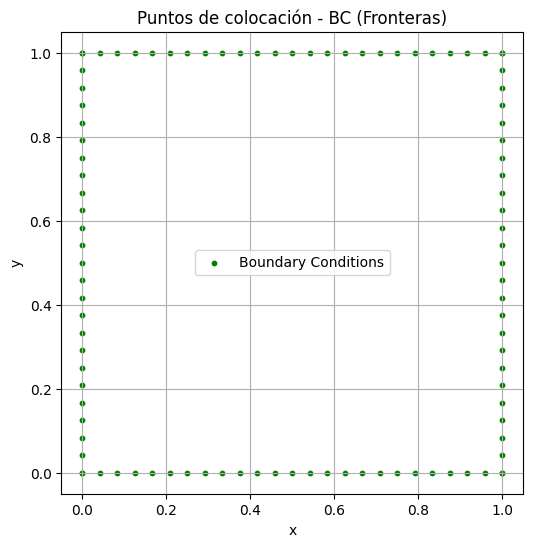

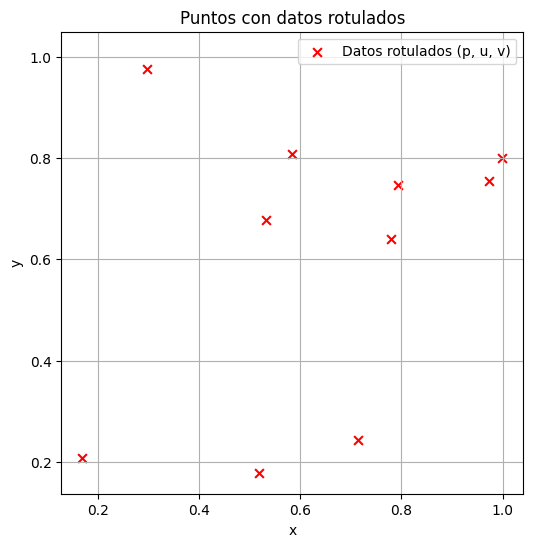


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.715  0.243    -0.0165    -0.1384     0.1227
 0.780  0.640    -0.0476    -0.1697     0.1095
 0.793  0.746    -0.0316    -0.0510     0.2083
 0.533  0.678     0.0064    -0.0258    -0.0036
 0.170  0.209    -0.0016    -0.0087    -0.0344
 0.584  0.809     0.0032    -0.0048    -0.0075
 0.298  0.976    -0.0609    -0.1772     0.0378
 0.999  0.801     0.0620     0.9478    -0.0006
 0.972  0.754    -0.0487     0.5752     0.0265
 0.518  0.177     0.0062    -0.0144    -0.0007


In [3]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

# Aleatorio en interior
x_pde_rand = np.random.uniform(0.0, 1.0, Npde)
y_pde_rand = np.random.uniform(0.0, 1.0, Npde)

# Regular en interior (malla tipo grilla)
n_side = int(np.sqrt(Npde))
x_grid = np.linspace(0, 1, n_side)
y_grid = np.linspace(0, 1, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

# Un pequeño conjunto sobre la frontera para incluir bordes
N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC (regular en bordes) ---

Nbc_per_edge = Nbc // 4

x_bc_top = np.linspace(0, 1, Nbc_per_edge)
y_bc_top = np.ones_like(x_bc_top)

x_bc_bottom = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom = np.zeros_like(x_bc_bottom)

y_bc_left = np.linspace(0, 1, Nbc_per_edge)
x_bc_left = np.zeros_like(y_bc_left)

y_bc_right = np.linspace(0, 1, Nbc_per_edge)
x_bc_right = np.ones_like(y_bc_right)

x_bc = np.concatenate([x_bc_top, x_bc_bottom, x_bc_left, x_bc_right])
y_bc = np.concatenate([y_bc_top, y_bc_bottom, y_bc_left, y_bc_right])

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)

    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]

    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]

    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]

    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])


# PDE
plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio')
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', alpha=0.5, label='PDE - Regular')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos de colocación - PDE')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

# BC
plt.figure(figsize=(6, 6))
plt.scatter(x_bc, y_bc, s=10, c='green', label='Boundary Conditions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos de colocación - BC (Fronteras)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

# Puntos rotulados
plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

# Tabla con valores interpolados
print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")


Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.